# Capacitance matrix and LOM analysis
### Prerequisite
You need to have a working local installation of Ansys.

## 1. Create the design in Metal

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [4]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

### In this example, the design consists of 4 qubits and 4 CPWs

In [5]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the defaults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        bus1 = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        bus2 = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

RouteMeander.get_template_options(design)

options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

asym = 140
cpw1 = connect('cpw1', 'Q1', 'bus2', 'Q2', 'bus1', '6.0 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'bus1', 'Q2', 'bus2', '6.1 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'bus2', 'Q4', 'bus1', '6.0 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'bus1', 'Q4', 'bus2', '6.1 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

## 2. Capacitance Analysis and LOM derivation using the analysis package - most users

### Capacitance Analysis
Select the analysis you intend to run from the `qiskit_metal.analyses` collection.<br>
Select the design to analyze and the tool to use for any external simulation

In [6]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

(optional) You can review and update the Analysis default setup following the examples in the next two cells.

In [7]:
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [22]:
# example: update single setting
c1.sim.setup.max_passes = 15
c1.sim.setup.min_passes = 1
c1.sim.setup.min_converged_passes = 3
# example: update multiple settings
c1.sim.setup_update(solution_order = 'Medium', auto_increase_solution_order = 'False')

c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 4.8,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 1,
 'min_converged_passes': 3,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'False',
 'solution_order': 'Medium',
 'solver_type': 'Iterative'}

Analyze a single qubit with 2 endcaps using the default (or edited) analysis setup. Then show the capacitance matrix (from the last pass).

You can use the method `run()` instead of `sim.run()` in the following cell if you want to run both cap extraction and lom analysis in a single step. If so, make sure to also tweak the setup for the lom analysis. The input parameters are otherwise the same for the two methods. 

In [9]:
c1.sim.renderer.stop()

True

In [20]:
c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'readout'), ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix

INFO 04:58PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 04:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:58PM [analyze]: Analyzing setup Setup


PyAEDT INFO: Python version 3.11.13 (main, Aug  8 2025, 17:07:28) [Clang 20.1.4 ].


INFO:Global:Python version 3.11.13 (main, Aug  8 2025, 17:07:28) [Clang 20.1.4 ].


PyAEDT INFO: PyAEDT version 0.23.0.


INFO:Global:PyAEDT version 0.23.0.


PyAEDT INFO: Returning found Desktop session with PID 2301150!


INFO:Global:Returning found Desktop session with PID 2301150!


PyAEDT INFO: Project Project25 set to active.


INFO:Global:Project Project25 set to active.


PyAEDT INFO: Active Design set to Design_q3d


INFO:Global:Active Design set to Design_q3d


PyAEDT INFO: Aedt Objects correctly read


INFO:Global:Aedt Objects correctly read


PyAEDT INFO: Project Project25 Saved correctly


INFO:Global:Project Project25 Saved correctly


PyAEDT INFO: Solving design setup Setup


INFO:Global:Solving design setup Setup


PyAEDT INFO: Design setup Setup solved correctly in 0.0h 0.0m 47.0s


INFO:Global:Design setup Setup solved correctly in 0.0h 0.0m 47.0s
INFO 04:59PM [get_matrix]: Exporting matrix data to (/tmp/tmpjz1z0b7l.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 1, False


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Modeler class has been initialized! Elapsed time: 0m 0sec
INFO 04:59PM [get_matrix]: Exporting matrix data to (/tmp/tmpvjaucwrj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 1, False


PyAEDT INFO: Parsing /home/abhis/Ansoft/Project25.aedt.


INFO:Global:Parsing /home/abhis/Ansoft/Project25.aedt.


PyAEDT INFO: File /home/abhis/Ansoft/Project25.aedt correctly loaded. Elapsed time: 0m 0sec


INFO:Global:File /home/abhis/Ansoft/Project25.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015161275863647461


INFO:Global:aedt file load time 0.015161275863647461


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


INFO:Global:PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.


Time to initialize solution data:0.0007495880126953125
Time to initialize solution data:0.00778651237487793
PyAEDT ERROR: Sweep is invalid. Provide a valid sweep.


ERROR:Global:Sweep is invalid. Provide a valid sweep.
ERROR 04:59PM [get_matrix]: Matrix data file was not created: /tmp/tmpvjaucwrj.txt


PyAEDT INFO: Export Convergence to  /tmp/tmpz4vnamebCG.conv


INFO:Global:Export Convergence to  /tmp/tmpz4vnamebCG.conv


,bus1_connector_pad_Q1,bus2_connector_pad_Q1,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
bus1_connector_pad_Q1,51.498329,-0.422947,-34.639561,-1.566272,-13.725586,-0.205320
bus2_connector_pad_Q1,-0.422947,55.721320,-36.922762,-14.496925,-1.853338,-1.036508
ground_main_plane,-34.639561,-36.922762,239.758463,-31.521074,-38.254224,-37.764083
pad_bot_Q1,-1.566272,-14.496925,-31.521074,100.526514,-31.151456,-19.565424
pad_top_Q1,-13.725586,-1.853338,-38.254224,-31.151456,89.927543,-2.250023
readout_connector_pad_Q1,-0.205320,-1.036508,-37.764083,-19.565424,-2.250023,61.908723


(otional - case-dependent)<br>If the previous cell was interrupted due to license limitations and for any reason you finally manually launched the simulation from the renderer GUI (outside qiskit-metal) you might be able to recover the simulation results by uncommenting and executing the following cell

In [11]:
# c1.sim._get_results_from_renderer()
# c1.sim.capacitance_matrix

The last variables you pass to the `run()` or `sim.run()` methods, will be stored in the `sim.setup` dictionary under the key `run`. You can recall the information passed by either accessing the dictionary directly, or by using the print handle below.

In [9]:
# c1.setup.run    <- direct access
c1.sim.print_run_args()

This analysis object run with the following kwargs:
{}



You can re-run the analysis after varying the parameters.<br>
Not passing the parameter `components` to the `sim.run()` method, skips the rendering and tries to run the analysis on the latest design. If a design is not found, the full metal design is rendered.

In [23]:
c1.sim.setup.freq_ghz = 4.8
c1.sim.run()
c1.sim.capacitance_matrix

INFO 05:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:42PM [analyze]: Analyzing setup Setup


PyAEDT INFO: Project Project25 Saved correctly


INFO:Global:Project Project25 Saved correctly


PyAEDT INFO: Solving design setup Setup


INFO:Global:Solving design setup Setup


PyAEDT INFO: Design setup Setup solved correctly in 0.0h 0.0m 40.0s


INFO:Global:Design setup Setup solved correctly in 0.0h 0.0m 40.0s
INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmpdthzw3ns.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 1, False
INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmpwroxn80o.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 1, False


PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.
INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 1, returning 6x6 matrix
INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmp88lgew0g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 2, False


Time to initialize solution data:0.0010538101196289062
Time to initialize solution data:0.008561849594116211
PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.
INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 2, returning 6x6 matrix
INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmph2e900b_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 3, False


Time to initialize solution data:0.0008080005645751953
Time to initialize solution data:0.008568048477172852
PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.
INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 3, returning 6x6 matrix
INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmpm6atd6rt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 4, False


Time to initialize solution data:0.0006830692291259766
Time to initialize solution data:0.006650209426879883
PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.
INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 4, returning 6x6 matrix
INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmpu98iafqe.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 5, False


Time to initialize solution data:0.00043320655822753906
Time to initialize solution data:0.006417036056518555
PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.
INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 5, returning 6x6 matrix
INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmp9hngkxl3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 6, False


Time to initialize solution data:0.0006120204925537109
Time to initialize solution data:0.007294416427612305
PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.


Time to initialize solution data:0.0004949569702148438


INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 6, returning 6x6 matrix
INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmpoap0_1tx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 7, False


Time to initialize solution data:0.007531881332397461
PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.
INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 7, returning 6x6 matrix


Time to initialize solution data:0.0005819797515869141
Time to initialize solution data:0.00752568244934082


INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmp762cvpdr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 8, False


PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.


Time to initialize solution data:0.0005850791931152344


INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 8, returning 6x6 matrix


Time to initialize solution data:0.00848841667175293


INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmp7in_cm1n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 9, False


PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.
INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 9, returning 6x6 matrix
INFO 05:43PM [get_matrix]: Exporting matrix data to (/tmp/tmpfh6wrabl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4800000000, Maxwell, 10, False


Time to initialize solution data:0.0005278587341308594
Time to initialize solution data:0.00759124755859375
PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.
INFO 05:43PM [get_matrix]: PyAEDT post.get_solution_data() succeeded for pass 10, returning 6x6 matrix


Time to initialize solution data:0.0005533695220947266
Time to initialize solution data:0.006943225860595703
PyAEDT INFO: Export Convergence to  /tmp/tmp9zuipt5mCG.conv


INFO:Global:Export Convergence to  /tmp/tmp9zuipt5mCG.conv


,bus1_connector_pad_Q1,bus2_connector_pad_Q1,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
bus1_connector_pad_Q1,50.665804,-0.422541,-34.047248,-1.566165,-13.500396,-0.204514
bus2_connector_pad_Q1,-0.422541,54.945537,-36.349894,-14.289846,-1.837536,-1.028348
ground_main_plane,-34.047248,-36.349894,239.245066,-31.550365,-38.192024,-37.189720
pad_bot_Q1,-1.566165,-14.289846,-31.550365,99.558369,-30.711090,-19.241256
pad_top_Q1,-13.500396,-1.837536,-38.192024,-30.711090,89.198661,-2.225893
readout_connector_pad_Q1,-0.204514,-1.028348,-37.189720,-19.241256,-2.225893,61.006620


In [20]:
type(c1.sim.capacitance_matrix)

pandas.core.frame.DataFrame

### Lumped oscillator model (LOM)

Using capacitance matrices obtained from each pass, save the many parameters of the Hamiltonian of the system. `get_lumped_oscillator()` operates on 4 setup parameters: <br><br>
Lj: float <br>
Cj: float <br>
fr: Union[list, float] <br>
fb: Union[list, float] <br>

In [24]:
c1.sim.capacitance_all_passes

{1: array([[ 4.41534254e-17, -3.70463518e-19, -3.12553701e-17,
         -1.40294596e-18, -1.04350825e-17, -1.68267092e-19],
        [-3.70463518e-19,  4.64457777e-17, -3.26429964e-17,
         -1.17072744e-17, -5.69928871e-19, -2.86114495e-19],
        [-3.12553701e-17, -3.26429964e-17,  2.41496656e-16,
         -2.88997647e-17, -3.63124312e-17, -3.40932286e-17],
        [-1.40294596e-18, -1.17072744e-17, -2.88997647e-17,
          8.59860889e-17, -2.61661420e-17, -1.61499249e-17],
        [-1.04350825e-17, -5.69928871e-19, -3.63124312e-17,
         -2.61661420e-17,  7.73764326e-17, -1.92217102e-18],
        [-1.68267092e-19, -2.86114495e-19, -3.40932286e-17,
         -1.61499249e-17, -1.92217102e-18,  5.34217954e-17]]),
 2: array([[ 4.63235746e-17, -4.20125007e-19, -3.15909137e-17,
         -1.32175002e-18, -1.20090256e-17, -2.02977655e-19],
        [-4.20125007e-19,  4.91181125e-17, -3.30261568e-17,
         -1.20468600e-17, -1.70845857e-18, -9.98364807e-19],
        [-3.15909137e-17

In [31]:
c1.setup.junctions = Dict({'Lj': 12.31, 'Cj': 2})
c1.setup.freq_readout = 7.0
c1.setup.freq_bus = [6.0, 6.2]

c1.run_lom()
c1.lumped_oscillator_all

[3, 4] [5 0 1]
Predicted Values

Transmon Properties
f_Q 24.518484 [GHz]
EC 9398.143315 [MHz]
EJ 13.273404 [GHz]
alpha 10875.320049 [MHz]
dispersion 26168457.871611 [KHz]
Lq 12.305036 [nH]
Cq 2.061070 [fF]
T1 10915.411595 [us]

**Coupling Properties**

tCqbus1 0.007553 [fF]
gbus1_in_MHz 49.404041 [MHz]
χ_bus1 0.146459 [MHz]
1/T1bus1 13.475551 [Hz]
T1bus1 11810.644622 [us]

tCqbus2 -0.006637 [fF]
gbus2_in_MHz -37.215379 [MHz]
χ_bus2 0.079188 [MHz]
1/T1bus2 0.625614 [Hz]
T1bus2 254397.914554 [us]

tCqbus3 0.005509 [fF]
gbus3_in_MHz 31.915739 [MHz]
χ_bus3 0.058769 [MHz]
1/T1bus3 0.479590 [Hz]
T1bus3 331856.276837 [us]
Bus-Bus Couplings
gbus1_2 0.007612 [MHz]
gbus1_3 0.010656 [MHz]
gbus2_3 0.005702 [MHz]


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,24.583992,9435.861985,13.273404,10958.033847,26311304.241562,"[48.06824075888773, -32.423674467497804, 33.84...","[0.1385838674719982, 0.06010147453029283, 0.06...",0.138584,48.068241
2,24.566953,9426.053741,13.273404,10936.528243,26274154.049109,"[49.10783064813207, -36.19094127060044, 30.127...","[0.14466025351719186, 0.07488176378732886, 0.0...",0.144660,49.107831
3,24.551163,9416.96336,13.273404,10916.594724,26239725.920806,"[48.158795438167125, -36.36714778337971, 30.79...","[0.13913807428646896, 0.0756150959789328, 0.05...",0.139138,48.158795
4,24.539076,9410.002848,13.273404,10901.330378,26213366.268251,"[47.588020178016684, -36.251867611391106, 30.7...","[0.135870629858341, 0.0751382002730855, 0.0544...",0.135871,47.588020
5,24.530734,9405.199134,13.273404,10890.795245,26195175.475778,"[48.4814860549457, -36.31260302285331, 30.7620...","[0.14102836439333039, 0.07539133245805807, 0.0...",0.141028,48.481486
6,24.525123,9401.967608,13.273404,10883.707827,26182938.738966,"[48.93173554954228, -36.82307432727378, 31.338...","[0.14366537394892331, 0.07752666285193076, 0.0...",0.143665,48.931736
7,24.520763,9399.455994,13.273404,10878.19917,26173428.335096,"[49.1907599722032, -37.02506255134703, 31.6259...","[0.1451946114969077, 0.07838011816376093, 0.05...",0.145195,49.190760
8,24.518484,9398.143315,13.273404,10875.320049,26168457.871611,"[49.40404109591023, -37.215378692446265, 31.91...","[0.14645861751946998, 0.07918827901434052, 0.0...",0.146459,49.404041


Design "Design_q3d" info:
	# eigenmodes    0
	# variations    1
DEBUG plot_convergence: x_values = [1. 2. 3. 4. 5. 6. 7. 8.]
DEBUG plot_convergence: alpha_data = [10958.03384695 10936.52824321 10916.59472439 10901.33037787
 10890.79524535 10883.70782708 10878.19916979 10875.3200489 ]
DEBUG plot_convergence: freq_data = [24583.99209313 24566.95273401 24551.16349923 24539.07563621
 24530.73433621 24525.12348438 24520.76286078 24518.48389652]
DEBUG plot_convergence: alpha_valid_mask = [ True  True  True  True  True  True  True  True] (sum=8)
DEBUG plot_convergence: freq_valid_mask = [ True  True  True  True  True  True  True  True] (sum=8)
DEBUG: Alpha line created: Line2D(Alpha)
DEBUG: Freq line created: Line2D(Frequency)
DEBUG: Alpha y-limits set to (10867.048669095528, 10966.3052267584)
DEBUG: Freq y-limits set to (24511.933076864625, 24590.5429127889)


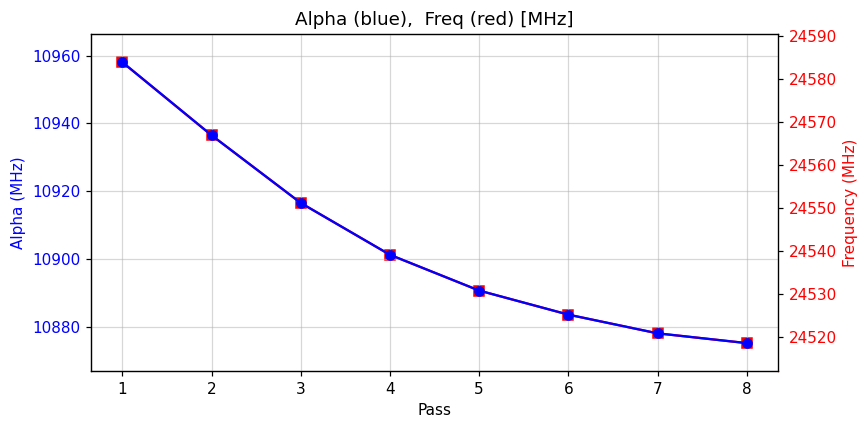

In [38]:
%matplotlib inline
c1.plot_convergence();
# c1.plot_convergence_chi()

Once you are done with your analysis, please close it with `close()`. This will free up resources currently occupied by qiskit-metal to communiate with the tool.

In [12]:
c1.sim.close()

PyAEDT INFO: Desktop has been released and closed.


INFO:Global:Desktop has been released and closed.


## 3. Directly access the renderer to modify other parameters

In [ ]:
c1.sim.start()
c1.sim.renderer

PyAEDT INFO: Python version 3.11.13 (main, Aug  8 2025, 17:07:28) [Clang 20.1.4 ].


INFO:Global:Python version 3.11.13 (main, Aug  8 2025, 17:07:28) [Clang 20.1.4 ].


PyAEDT INFO: PyAEDT version 0.23.0.


INFO:Global:PyAEDT version 0.23.0.


PyAEDT INFO: Initializing new Desktop session.


INFO:Global:Initializing new Desktop session.


PyAEDT WARNING: Argument `specified_version` is deprecated for method `__init__`; use `version` instead.


PyAEDT WARNING: Argument `new_desktop_session` is deprecated for method `__init__`; use `new_desktop` instead.


PyAEDT INFO: Log on console is enabled.


INFO:Global:Log on console is enabled.


PyAEDT INFO: Log on file /tmp/pyaedt_abhis_d76576dc-3afa-4f27-98b3-542e0dee1b01.log is enabled.


INFO:Global:Log on file /tmp/pyaedt_abhis_d76576dc-3afa-4f27-98b3-542e0dee1b01.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


INFO:Global:Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


INFO:Global:Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path /ansys_inc/v252/AnsysEM


INFO:Global:AEDT installation Path /ansys_inc/v252/AnsysEM


Every renderer will have its own collection of methods. Below an example with q3d

##### Prepare and run a collection of predefined setups

This is equivalent to going to the Project Manager panel in Ansys, right clicking on Analysis within the active Q3D design, selecting "Add Solution Setup...", and choosing/entering default values in the resulting popup window. You might want to do this to keep track of different solution setups, giving each of them a different/specific name.

In [ ]:
setup = c1.sim.renderer.new_ansys_setup(name = "Setup_demo", max_passes = 6)

You can directly pass to `new_ansys_setup` all the setup parameters. Of course you will then need to run the individual setups by name as well.

In [ ]:
c1.sim.renderer.analyze_setup(setup.name)

##### Get the capactiance matrix at a different pass

You might want to use this if you intend to know what was the matrix at a different pass of the simulation.

In [ ]:
# Using the analysis results, get its capacitance matrix as a dataframe.
c1.sim.renderer.get_capacitance_matrix(variation = '', solution_kind = 'AdaptivePass', pass_number = 5)

### Code to swap rows and columns in capacitance matrix
from qiskit_metal.analyses.quantization.lumped_capacitive import df_reorder_matrix_basis

df_reorder_matrix_basis(fourq_q3d.get_capacitance_matrix(), 1, 2)

##### Close the renderer

In [ ]:
c1.sim.close()